# Persian NER [ARMAN, PEYMA, COMPOSITE]

This task aims to extract named entities in the text, such as names and label with appropriate NER classes such as locations, organizations, etc. The datasets used for this task contain sentences that are marked with IOB format. In this format, tokens that are not part of an entity are tagged as ”O,” the ”B” tag corresponds to the first word of an object, and the ”I” tag corresponds to the rest of the terms of the same entity. Both ”B” and ”I” tags are followed by a hyphen (or underscore), followed by the entity category. Therefore, the NER task is a multi-class token classification problem that labels the tokens upon being fed a raw text. There are two primary datasets used in Persian NER, ARMAN, and PEYMA. In ParsBERT, we prepared ner for both datasets as well as a combination of both datasets.


## ARMAN:
ARMAN dataset holds 7,682 sentences with 250,015 sentences tagged over six different classes.

1. Organization
2. Location
3. Facility
4. Event
5. Product
6. Person


|     Label    |   #   |
|:------------:|:-----:|
| Organization | 30108 |
|   Location   | 12924 |
|   Facility   |  4458 |
|     Event    |  7557 |
|    Product   |  4389 |
|    Person    | 15645 |

**Download**
You can download the dataset from [here](https://github.com/HaniehP/PersianNER)



## PEYMA:
PEYMA dataset includes 7,145 sentences with a total of 302,530 tokens from which 41,148 tokens are tagged with seven different classes: 

- Organization
- Money
- Location
- Date
- Time
- Person
- Percent

|     Label    |   #   |
|:------------:|:-----:|
| Organization | 16964 |
|     Money    |  2037 |
|   Location   |  8782 |
|     Date     |  4259 |
|     Time     |  732  |
|    Person    |  7675 |
|    Percent   |  699  |

**Download**
You can download the dataset from [here](http://nsurl.org/tasks/task-7-named-entity-recognition-ner-for-farsi/)



In [2]:
# connect to GPU
!nvidia-smi

Thu Jan 21 19:18:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load Libraries

In [3]:
# install requiered package

# install requiered packages
# !pip install -qU hazm
!pip install transformers
!pip install seqeval
!pip install tqdm


     |████████████████████████████████| 1.8MB 17.3MB/s 
     |████████████████████████████████| 2.9MB 60.3MB/s 
     |████████████████████████████████| 890kB 56.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=dd2da5191eea382e72a54b3e875b767af5efe0f735756555f0a5b7dd8a34a789
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 51kB 7.8MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp36-none-any.whl size=16171 sha256=b354719357f8e2bb609b95ffec902417eb88e6510fb2c4eab0103ca5ff639e26
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [4]:
# import requiered package

from google.colab import drive
drive.mount('/content/drive')

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

from __future__ import absolute_import, division, print_function, unicode_literals
import os

import numpy as np
import pandas as pd
import time
import datetime
import seqeval
import tqdm

import tensorflow as tf
import torch, gc
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import transformers 
from transformers import AutoTokenizer, BertConfig, TFAutoModelForTokenClassification, AdamW
from transformers import BertForTokenClassification, BertTokenizer, BertConfig
from transformers import get_linear_schedule_with_warmup
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from seqeval.metrics import f1_score, accuracy_score, classification_report


# import hazm

print()
print('tensorflow', tf.__version__)
print('transformers', transformers.__version__)
print('numpy', np.__version__)
print('pandas', pd.__version__)
print()

if tf.test.gpu_device_name() != '/device:GPU:0':
    print()
    print('WARNING: GPU device not found.')
else:
    print()
    print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))


Mounted at /content/drive

tensorflow 2.4.0
transformers 4.2.2
numpy 1.19.5
pandas 1.1.5


SUCCESS: Found GPU: /device:GPU:0


In [5]:
# determine the gpu for allocating tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
n_gpu

1

In [6]:
torch.cuda.get_device_name(0)


'Tesla T4'

# Define constant values

In [7]:
model_name_or_path = 'HooshvareLab/bert-fa-base-uncased'
MAX_LEN = 64
batch_size = 32
epochs = 2


#BERT Initialization

In [8]:
!wget https://github.com/hooshvare/parsbert

--2021-01-21 19:19:59--  https://github.com/hooshvare/parsbert
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘parsbert’

parsbert                [ <=>                ] 168.67K  --.-KB/s    in 0.01s   

2021-01-21 19:19:59 (17.3 MB/s) - ‘parsbert’ saved [172721]



In [9]:
print('Loading BERT tokenizer')
tokenizer = BertTokenizer.from_pretrained(model_name_or_path, do_lower_case = True) 

Loading BERT tokenizer


# Dataset

In [10]:
# Load Data
# unzip dataset
%cd /content/drive/MyDrive/NLP_HW3 
# !pwd
if not os.path.exists('./dataset/peyma/'):
  !unzip peyma.zip -d 'dataset'
%cd dataset/peyma

/content/drive/MyDrive/NLP_HW3
/content/drive/MyDrive/NLP_HW3/dataset/peyma


In [11]:
# function to work with data and extract them

def read_file(fileName):
  sentences = []
  with open(fileName) as f_in:
      lines = f_in.readlines()
      s = []
      for line in lines:
        if not line.strip():
          sentences.append(s)
          s = []
        else:
          s.append(line.strip())
        
  return sentences
  # print(lines[0:100])
def remove_blank_line(fileName):
  outputfile_name = fileName.split('.')[0] + 'NBlankLine.txt'
  with open(fileName) as infile, open(outputfile_name, 'w') as outfile:
      for line in infile:
          if not line.strip(): continue  # skip the empty line
          outfile.write(line)  # non-empty line. Write it to output
  return outputfile_name

import csv
def read_data(fileName):
  return pd.read_csv(fileName, delimiter='|', header=None, names=['Word','Tag'],quoting=csv.QUOTE_NONE)

def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = ['[CLS]']
    labels = ['O']

    for word, label in zip(sentence, text_labels):
      # Tokenize the word and count # of subwords the word is broken into
      tokenized_word = tokenizer.tokenize(word)
      n_subwords = len(tokenized_word)

      # Add the tokenized word to the final tokenized word list
      tokenized_sentence.extend(tokenized_word)

      # Add the same label to the new list of labels `n_subwords` times
      labels.extend([label] * n_subwords)
    labels.append('O')
    tokenized_sentence.append('[SEP]')

    return tokenized_sentence, labels

def get_data_part(file_name):
  sen = read_file(file_name)
  sentences = [[t.split('|')[0] for t in s_t] for s_t in sen]
  labels = [[t.split('|')[1] for t in s_t] for s_t in sen]
  # some preprocessing
  for i,l in enumerate(sentences):
    l = sentences[i]
    for j,s in enumerate(l):
      if not s:
        print(labels[i])
        sentences[i][j] = '|'
        labels[i][j] = 'O'

  
  # encode
  tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(t, l)
    for t, l in zip(sentences, labels)
  ]


  # print(len(tokens))
  # print(len(labels))
  # print(tokenized_texts_and_labels[:100])
  tokens_f = [pair[0] for pair in tokenized_texts_and_labels]
  labels_f = [pair[1] for pair in tokenized_texts_and_labels]
  # print(tokens_f)
  # print(labels_f)



  # # print('raw', tokens[2])
  # # print('tokenezed', tokenizer.tokenize(tokens[2]))
  # # print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(tokens[2])))
  input_ids = [tokenizer.convert_tokens_to_ids(t) for t in tokens_f]
  tags_f = [[tag2idx.get(l) for l in lab] for lab in labels_f]

  return sentences, labels, input_ids, tags_f



# read data

In [12]:
train_f = remove_blank_line('train.txt')
# test_f = remove_blank_line('test.txt')
# dev_f = remove_blank_line('dev.txt')

train_df = read_data(train_f)
# test_df = read_data(test_f)
# dev_df = read_data(dev_f)
# train_df.head()

train_sen = read_file('train.txt')
test_sen = read_file('test.txt')
# dev_sen = read_file('dev.txt')
# train_sen



# do processing to extract number of unique labels

In [13]:
# print data information
data = train_df
print('data information')
print(data.info(), '\n')

# print missing values information
print('missing values stats')
print(data.isnull().sum(), '\n')

# print some missing values
print('some missing values')
print(data[data['Word'].isnull()].iloc[:5], '\n')

data information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243546 entries, 0 to 243545
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Word    243544 non-null  object
 1   Tag     243546 non-null  object
dtypes: object(2)
memory usage: 3.7+ MB
None 

missing values stats
Word    2
Tag     0
dtype: int64 

some missing values
       Word Tag
134369  NaN    
134391  NaN     



In [14]:
# finally
# extract tags
tag_values = list(set(train_df["Tag"].values))
tag_values.append("PAD")
tag_values = [t for i,t in enumerate(tag_values)if t.strip()]
tag2idx = {t: i for i, t in enumerate(tag_values)}
tag2idx

{'B_DAT': 1,
 'B_LOC': 5,
 'B_MON': 3,
 'B_ORG': 8,
 'B_PCT': 11,
 'B_PER': 2,
 'B_TIM': 10,
 'I_DAT': 0,
 'I_LOC': 14,
 'I_MON': 6,
 'I_ORG': 4,
 'I_PCT': 7,
 'I_PER': 12,
 'I_TIM': 13,
 'O': 9,
 'PAD': 15}

In [15]:
sentences, labels, input_ids, tags_f = get_data_part('train.txt')
print(input_ids[:9])
print(tags_f[:9])


['B_ORG', ' ', 'B_PER', 'I_PER', 'O', 'O', 'O']
['B_ORG', ' ', 'B_PER', 'I_PER', 'O', 'O', 'O']
[[2, 5187, 8590, 5141, 3169, 1379, 4655, 4066, 1379, 4824, 3852, 3589, 4], [2, 2789, 3361, 6000, 4153, 1348, 7398, 75488, 4130, 4009, 6990, 7344, 2930, 2799, 3856, 2801, 3131, 5112, 3036, 2791, 18656, 3541, 6343, 4017, 4434, 2786, 3768, 3639, 1379, 3114, 2806, 1348, 3017, 1014, 2799, 3211, 2789, 15342, 15034, 5112, 1379, 3639, 2786, 2930, 1348, 2802, 2897, 3821, 40032, 2791, 4701, 9047, 5507, 3168, 1012, 4], [2, 3051, 16337, 3767, 2786, 3753, 6783, 1348, 5039, 4017, 2789, 3014, 3036, 2791, 11404, 3639, 1379, 3563, 3206, 2847, 2803, 3012, 3027, 2806, 1012, 4], [2, 2931, 3251, 2974, 1014, 5571, 2799, 3211, 2789, 4856, 4433, 4017, 1379, 3779, 2786, 2930, 2964, 1348, 6194, 7297, 2871, 2800, 4017, 11997, 2938, 4001, 2801, 2806, 2800, 3870, 11656, 45663, 2924, 1012, 4], [2, 2789, 3138, 2793, 19355, 2800, 50764, 4017, 1379, 3563, 1379, 3639, 5404, 3947, 2801, 8690, 25881, 2009, 2801, 3768, 3563, 13

# padding 

In [16]:
print("max length: ",max(len(id) for id in input_ids))  
tag2idx["PAD"]

max length:  421


15

In [17]:
input_ids = pad_sequences(input_ids,
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

tags = pad_sequences(tags_f,
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")



# attention mask

In [18]:
# create attention masks
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

# Training and validation split

In [19]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.2)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.2)

# convert to tensors

In [20]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

# manage my data

In [21]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(val_inputs, val_masks, val_tags)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# train the model

In [22]:
if tf.test.gpu_device_name() != '/device:GPU:0':
    print()
    print('WARNING: GPU device not found.')
else:
    print()
    print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))


SUCCESS: Found GPU: /device:GPU:0


In [23]:


model = BertForTokenClassification.from_pretrained(model_name_or_path, num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False )
config = BertConfig.from_pretrained(model_name_or_path)

transformers.__version__

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not init

'4.2.2'

In [24]:
# tell pytorch to run this model on GPU

gc.collect()
torch.cuda.empty_cache()
model.cuda()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

# optimizer and learning rate

In [25]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)


In [26]:
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


# training loop

In [27]:
def format_time(elapsed):
  # takes time in seconds and return in hh:mm:ss

  # round to nearest second
  elapsed_rounded = int(round(elapsed))

  # format
  return str(datatime.timedelta(seconds=elapsed_rounded))

def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat)/len(labels_flat)

In [28]:
# import random

# seed_val = 2021
# random.seed(seed_val)
# np.random.seed(seed_val)
# torch.manual_seed(seed_val)
# tourch.cuda.manual_seed_all(seed_val)

# loss_values = []
# for epoch_i in range(0,epochs):
#   print("")
#   print('================ Epoch {:} / {:} ================'.format(epoch_i+1, epochs))
#   print('Training...')
#   t0 = time.time()
#   total_loss = 0
#   model.train()
#   for step, batch in enumerate(train_dataloader):
#     if step%40 == 0 and not step==0:
#       elapsed = format_time(time.time-t0)
#       print(' Batch {:>5,} of {:>5,}. Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
#       b_inputs_ids = batch[0].to(device)
#       b_input_mask = batch[1].to(device)
#       b_labels = batch[2].to(device)

#       outputs = model(b_inputs_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
#       loss = outputs[0]
#       total_loss += loss.item()
#       loss.backward()
#       torch.nn.utils.clip_gard_norm_(model.parameters(), 1.0)
#       optimizer.step()
#       scheduler.step()
#     ave_train_loss = total_loss / len(train_dataloader)
#     loss_values.append(ave_train_loss)
#     print("")
#     print("average training loss: {0:.2f}".format(ave_train_loss))
#     print("training epoch took: {:}".format(format_time(time.time()-t0)))


In [29]:
!nvidia-smi

Thu Jan 21 19:20:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W /  70W |   1721MiB / 15079MiB |     39%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [30]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

gc.collect()
torch.cuda.empty_cache()
for _ in tqdm.trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # # tara
        # outputs = model(b_input_ids, token_type_ids=None,
        #                     attention_mask=b_input_mask, labels=b_labels)
        # logits = outputs[0]

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(validation_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    # print("Validation F1-Score: {}".format(flat_accuracy(pred_tags, valid_tags)))
    print()


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Average train loss: 0.1944278980331931


Epoch:  50%|█████     | 1/2 [01:20<01:20, 80.51s/it]

Validation loss: 0.07035082074649193
Validation Accuracy: 0.9780156473583468

Average train loss: 0.04129976876061502


Epoch: 100%|██████████| 2/2 [02:44<00:00, 82.43s/it]

Validation loss: 0.06300683332351494
Validation Accuracy: 0.9810633513593875



In [32]:
len(pred_tags)


53811

In [33]:
# Test
loss_values

[0.1944278980331931, 0.04129976876061502]

In [34]:
validation_loss_values

[0.07035082074649193, 0.06300683332351494]

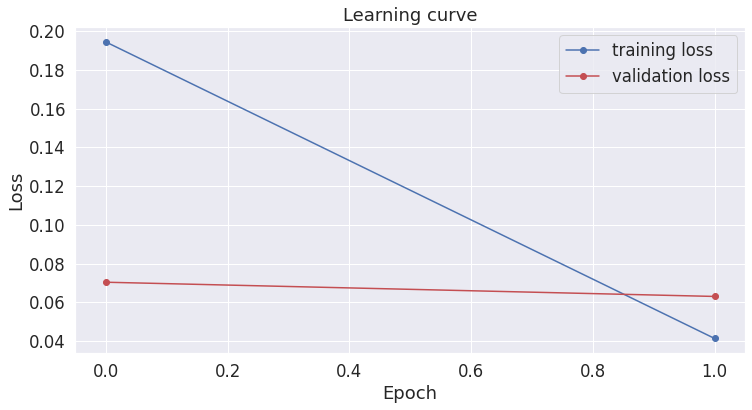

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


# Test model

In [36]:
tag2idx
def get_key(val, my_dict): 
  for key, value in my_dict.items(): 
    if val == value: 
      return key 

def convert_to_tag(base, my_dict):
  return [get_key(l, base) for l in my_dict]

In [37]:
sentences_test, labels_test, input_ids_test, tags_f_test = get_data_part('test.txt')

tokenized_sentences = []
tags_f_t = []
input_ids = []
labels_hid = []
# tags_f_t_all = []
for i,s in enumerate(sentences_test):
  s_t = ' '.join(s)
  tokenized_sentence = tokenizer.encode(s_t)
  tokenized_sentences.append(tokenized_sentence)
  tags_f_t.append(convert_to_tag(tag2idx, tags_f_test[i]))
  input_ids = torch.tensor([tokenized_sentence]).cuda() 
  with torch.no_grad():
    output = model(input_ids)
  label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

  # join bpe split tokens
  tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
  # print(tokens)
  new_tokens, new_labels, new_labels_hid = [], [], []
  for token, label_idx in zip(tokens, label_indices[0]):
      if token.startswith("##"):
          new_tokens[-1] = new_tokens[-1] + token[2:]
          new_labels_hid.append(tag_values[label_idx])
      else:
          new_labels.append(tag_values[label_idx])
          new_tokens.append(token)
          new_labels_hid.append(tag_values[label_idx])
  labels_hid.append(new_labels_hid)


print(classification_report(tags_f_t, labels_hid))







# print(len(new_labels_hid))
# print(len(tags_f_t[9]))
# print(new_labels_hid[1:-1])
# print(tags_f_t[9])
# # print(labels_test[8])

# print(new_tokens)

# for token, label in zip(new_tokens, new_labels):
#     print("{}\t{}".format(label, token))






['B_PER', 'O', 'B_PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '', 'B_PER', 'O', 'O', 'O']
['B_PER', 'O', 'B_PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '', 'B_PER', 'O', 'O', 'O']


/usr/local/lib/python3.6/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_ORG seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.6/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_LOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.6/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_ORG seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.6/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_LOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.6/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_PER seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.6/dist-packages/seqeval/metrics/sequence_labeling.py:171:

              precision    recall  f1-score   support

        _DAT       0.75      0.78      0.76       220
        _LOC       0.87      0.92      0.89       607
        _MON       0.65      0.77      0.70        26
        _ORG       0.83      0.83      0.83       716
        _PCT       0.81      0.88      0.85        50
        _PER       0.91      0.92      0.91       497
        _TIM       0.75      0.68      0.71        22

   micro avg       0.85      0.87      0.86      2138
   macro avg       0.79      0.82      0.81      2138
weighted avg       0.85      0.87      0.86      2138



In [38]:
!pip install sklearn_crfsuite

     |████████████████████████████████| 747kB 13.6MB/s 


In [39]:
import sklearn_crfsuite
from sklearn_crfsuite import metrics
# (tags_f_t, labels_hid))
# labels_hid
sorted_labels = list(tag2idx.keys())
print(sklearn_crfsuite.metrics.flat_classification_report(tags_f_t, labels_hid, labels=sorted_labels, digits=3))

              precision    recall  f1-score   support

       I_DAT      0.831     0.948     0.886       249
       B_DAT      0.851     0.832     0.841       220
       B_PER      0.956     0.954     0.955       497
       B_MON      0.800     0.923     0.857        26
       I_ORG      0.899     0.903     0.901      1149
       B_LOC      0.914     0.947     0.930       607
       I_MON      0.953     0.924     0.938        66
       I_PCT      0.927     0.905     0.916        42
       B_ORG      0.899     0.874     0.887       716
           O      0.996     0.992     0.994     32507
       B_TIM      0.889     0.727     0.800        22
       B_PCT      0.904     0.940     0.922        50
       I_PER      0.933     0.964     0.949       363
       I_TIM      0.821     0.958     0.885        24
       I_LOC      0.718     0.900     0.798       229
         PAD      0.000     0.000     0.000         0

   micro avg      0.983     0.983     0.983     36767
   macro avg      0.831   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
# print(sklearn_crfsuite.metrics.flat_classification_report(y_test, y_pred, labels=sorted_labels, digits=3))
sorted_labels

['I_DAT',
 'B_DAT',
 'B_PER',
 'B_MON',
 'I_ORG',
 'B_LOC',
 'I_MON',
 'I_PCT',
 'B_ORG',
 'O',
 'B_TIM',
 'B_PCT',
 'I_PER',
 'I_TIM',
 'I_LOC',
 'PAD']

# Setup

In [ ]:
texts = [
    "مدیرکل محیط زیست استان البرز با بیان اینکه با بیان اینکه موضوع شیرابه‌های زباله‌های انتقال یافته در منطقه حلقه دره خطری برای این استان است، گفت: در این مورد گزارشاتی در ۲۵ مرداد ۱۳۹۷ تقدیم مدیران استان شده است.",
    "به گزارش خبرگزاری تسنیم از کرج، حسین محمدی در نشست خبری مشترک با معاون خدمات شهری شهرداری کرج که با حضور مدیرعامل سازمان‌های پسماند، پارک‌ها و فضای سبز و نماینده منابع طبیعی در سالن کنفرانس شهرداری کرج برگزار شد، اظهار داشت: ۸۰٪  جمعیت استان البرز در کلانشهر کرج زندگی می‌کنند.",
    "وی افزود: با همکاری‌های مشترک بین اداره کل محیط زیست و شهرداری کرج برنامه‌های مشترکی برای حفاظت از محیط زیست در شهر کرج در دستور کار قرار گرفته که این اقدامات آثار مثبتی داشته و تاکنون نزدیک به ۱۰۰ میلیارد هزینه جهت خریداری اکس-ریس صورت گرفته است.",
]

peyma_translate = {
    "B_DAT": "تاریخ",
    "B_LOC": "موقعیت",
    "B_MON": "پول",
    "B_ORG": "سازمنان",
    "B_PCT": "درصد",
    "B_PER": "شخص",
    "B_TIM": "زمان",
    "I_DAT": "تاریخ",
    "I_LOC": "موقعیت",
    "I_MON": "پول",
    "I_ORG": "سازمان",
    "I_PCT": "درصد",
    "I_PER": "شخص",
    "I_TIM": "زمان",
    "O": None,
}
arman_translate = {
    "B-event": "رویداد",
    "B-fac": "امکانات",
    "B-loc": "موقعیت",
    "B-org": "سازمان",
    "B-pers": "شخص",
    "B-pro": "محصول",
    "I-event": "رویداد",
    "I-fac": "امکانات",
    "I-loc": "موقعیت",
    "I-org": "سازمان",
    "I-pers": "شخص",
    "I-pro": "محصول",
    "O": None
}

ner_translate = {
    "B-date": "تاریخ",
    "B-event": "رویداد",
    "B-facility": "امکانات",
    "B-location": "موقعیت",
    "B-money": "پول",
    "B-organization": "سازمان",
    "B-person": "شخص",
    "B-product": "محصول",
    "B-time": "زمان",
    "B-percent": "درصد",
    "I-date": "تاریخ",
    "I-event": "رویداد",
    "I-facility": "امکانات",
    "I-location": "موقعیت",
    "I-money": "پول",
    "I-organization": "سازمان",
    "I-person": "شخص",
    "I-product": "محصول",
    "I-time": "زمان",
    "I-percent": "درصد",
    "O": None
}

In [ ]:
normalizer = hazm.Normalizer()


def cleanize(text):
    """A way to normalize and even clean the text"""
    # clean text
    # do some fns
    return normalizer.normalize(text)


def parsbert_ner_load_model(model_name):
    """Load the model"""
    try:
        config = AutoConfig.from_pretrained(model_name)
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = TFAutoModelForTokenClassification.from_pretrained(model_name)
        labels = list(config.label2id.keys())

        return model, tokenizer, labels
    except:
        return [None] * 3

def parsbert_ner(texts, model_name, label_translate, visualize=True):
    """Predict and visualize the NER!"""
    global css_is_load
    
    css_is_load = False
    css = """<style>
    .ner-box {
        direction: rtl;
        font-size: 18px !important;
        line-height: 20px !important;
        margin: 0 0 15px;
        padding: 10px;
        text-align: justify;
        color: #343434 !important;
    }
    .token, .token span {
        display: inline-block !important;
        padding: 2px;
        margin: 2px 0;
    }
    .token.token-ner {
        background-color: #f6cd61;
        font-weight: bold;
        color: #000;
    }
    .token.token-ner .ner-label {
        color: #9a1f40;
        margin: 0px 2px;
    }
    </style>"""

    if not css_is_load:
        display(HTML(css))
        css_is_load = True

    model, tokenizer, labels = parsbert_ner_load_model(model_name)

    if not model or not tokenizer or not labels:
        return 'Something wrong has been happened!'
    
    output_predictions = []
    for sequence in texts:
        sequence = cleanize(sequence)
        tokens = tokenizer.tokenize(tokenizer.decode(tokenizer.encode(sequence)))
        inputs = tokenizer.encode(sequence, return_tensors="tf")
        outputs = model(inputs)[0]
        predictions = tf.argmax(outputs, axis=2)
        predictions = [(token, label_translate[labels[prediction]]) for token, prediction in zip(tokens, predictions[0].numpy())]
        
        if not visualize:
            output_predictions.append(predictions)
        else:
            pred_sequence = []
            for token, label in predictions:
                if token not in ['[CLS]', '[SEP]']:
                    if label:
                        pred_sequence.append(
                            '<span class="token token-ner">%s<span class="ner-label">%s</span></span>' 
                            % (token, label))
                    else:
                        pred_sequence.append(
                            '<span class="token">%s</span>' 
                            % token)
                
            html = '<p class="ner-box">%s</p>' % ' '.join(pred_sequence) 
            display(HTML(html))

    return output_predictions

# Persian ARMAN NER

In [ ]:
model_name = 'HooshvareLab/bert-base-parsbert-armanner-uncased'
_ = parsbert_ner(texts, model_name, arman_translate, visualize=True)

All model checkpoint layers were used when initializing TFBertForTokenClassification.

All the layers of TFBertForTokenClassification were initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-armanner-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForTokenClassification for predictions without further training.


# Persian PEYMA NER

In [ ]:
model_name = 'HooshvareLab/bert-base-parsbert-peymaner-uncased'
_ = parsbert_ner(texts, model_name, peyma_translate, visualize=True)

Some layers from the model checkpoint at HooshvareLab/bert-base-parsbert-peymaner-uncased were not used when initializing TFBertForTokenClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForTokenClassification were initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-peymaner-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForTokenClassification for predictions without further training.


# Persian ParsBERT NER

In [ ]:
model_name = 'HooshvareLab/bert-base-parsbert-ner-uncased'
_ = parsbert_ner(texts, model_name, ner_translate, visualize=True)

Some layers from the model checkpoint at HooshvareLab/bert-base-parsbert-ner-uncased were not used when initializing TFBertForTokenClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForTokenClassification were initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-ner-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForTokenClassification for predictions without further training.


In [ ]:
#@title Live Playground { display-mode: "form" }

submit_wd = widgets.Button(description='Send', disabled=False, button_style='success', tooltip='Submit')
text_wd = widgets.Textarea(placeholder='Please enter you text ...', rows=5, layout=Layout(width='90%'))

config_wd = widgets.RadioButtons(options=['ARMAN', 'PEYMA', 'ARMAN+PEYMA'], description='Select your model', disabled=False)

output_wd = widgets.Output()

display(HTML("""
<h2>Persian NER <small>[ARMAN, PEYMA, ARMAN+PEYMA]</small></h2>
<p style="padding: 2px 20px; margin: 0 0 20px;">
</p>
<br /><br />
"""))

display(config_wd)
display(text_wd)
display(submit_wd)
display(output_wd)

configs = {
    'ARMAN': [
        'HooshvareLab/bert-base-parsbert-armanner-uncased',
        arman_translate
    ], 
    'PEYMA': [
        'HooshvareLab/bert-base-parsbert-peymaner-uncased',
        peyma_translate
    ],
    'ARMAN+PEYMA': [
        'HooshvareLab/bert-base-parsbert-ner-uncased',
        ner_translate
    ]
}

def submit_text(sender):
    with output_wd:
        clear_output(wait=True)
        text = text_wd.value
        config = configs[config_wd.value]
        print('Predicting .... [please wait!]')
        _ = parsbert_ner([text], config[0], config[1], visualize=True)


submit_wd.on_click(submit_text)

RadioButtons(description='Select your model', options=('ARMAN', 'PEYMA', 'ARMAN+PEYMA'), value='ARMAN')

Textarea(value='', layout=Layout(width='90%'), placeholder='Please enter you text ...', rows=5)

Button(button_style='success', description='Send', style=ButtonStyle(), tooltip='Submit')

Output()

In [ ]:
!git init

Initialized empty Git repository in /content/.git/


In [ ]:
!git config --global user.email "gheshlaghitara@gmail.com"
!git config --global user.name "GhTara"
!git add -A

In [ ]:
!git commit -m “first commit”

error: pathspec 'commit”' did not match any file(s) known to git.
